In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import cv2
import os

def create_video_dataset(video_path, output_dir, lr_dir='low_res', hr_dir='high_res', scale=4):
    os.makedirs(os.path.join(output_dir, lr_dir), exist_ok=True)
    os.makedirs(os.path.join(output_dir, hr_dir), exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        hr_frame = cv2.resize(frame, (frame.shape[1], frame.shape[0]))
        hr_path = os.path.join(output_dir, hr_dir, f"frame_{frame_count:04d}.png")
        cv2.imwrite(hr_path, hr_frame)

        lr_frame = cv2.resize(frame, (frame.shape[1] // scale, frame.shape[0] // scale))
        lr_frame = cv2.resize(lr_frame, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
        lr_path = os.path.join(output_dir, lr_dir, f"frame_{frame_count:04d}.png")
        cv2.imwrite(lr_path, lr_frame)

        frame_count += 1
    cap.release()

sample_video_path = '/content/drive/My Drive/dolphinsrgan.mp4'
output_dataset_dir = '/content/drive/My Drive/video_dataset'

create_video_dataset(sample_video_path, output_dataset_dir)


In [9]:
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')


In [5]:
import os
output_dataset_dir = '/content/drive/My Drive/video_dataset'

In [7]:
import os
dataset_path = '/content/drive/My Drive/video_dataset'

In [8]:
from glob import glob
import tensorflow as tf
import numpy as np

def load_images(image_path, target_size):
    images = []
    for img_path in glob(os.path.join(image_path, '*')):
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

lr_images_path = os.path.join(dataset_path, 'high_res')
hr_images_path = os.path.join(dataset_path, '')

lr_images = load_images(lr_images_path, target_size=(64, 64))
hr_images = load_images(hr_images_path, target_size=(256, 256))

print(f"Loaded {len(lr_images)} LR images and {len(hr_images)} HR images")

Loaded 165 LR images and 165 HR images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


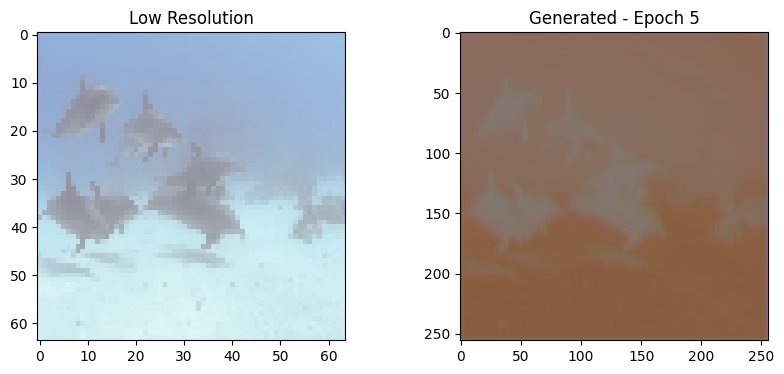

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


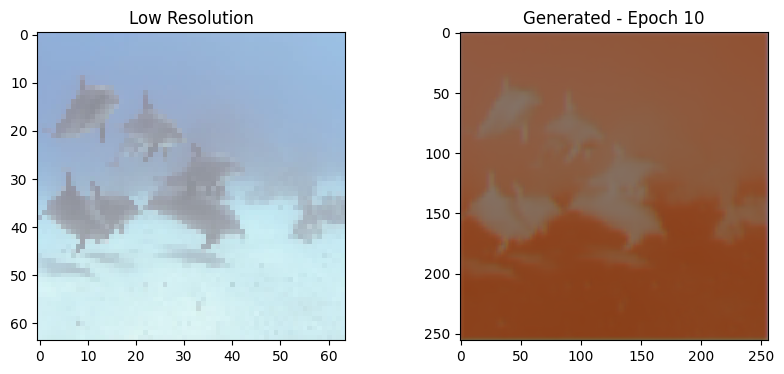

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


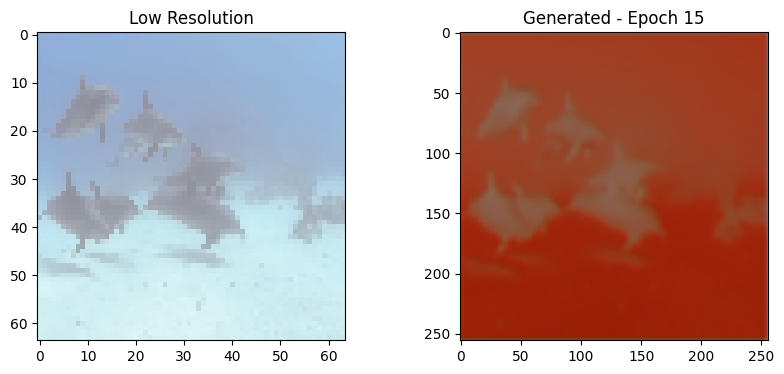

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


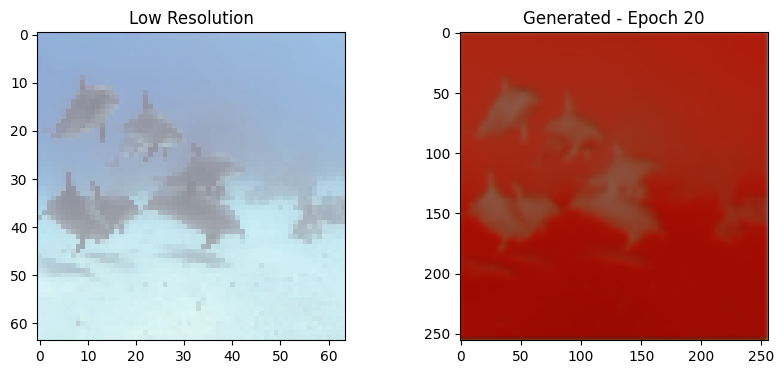

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dense, Flatten, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

# Generator
def build_generator():
    inputs = Input(shape=(64, 64, 3))
    x = UpSampling2D(size=2)(inputs)
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = UpSampling2D(size=2)(x)
    x = Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(3, kernel_size=3, padding='same', activation='tanh')(x)
    return Model(inputs, x, name='generator')

# Discriminator
def build_discriminator():
    inputs = Input(shape=(256, 256, 3))
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs, x, name='discriminator')

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
lr_inputs = Input(shape=(64, 64, 3))
gen_hr = generator(lr_inputs)
validity = discriminator(gen_hr)
combined = Model(lr_inputs, validity)
combined.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

epochs = 2000
batch_size = 16

for epoch in range(epochs):
    idx = np.random.randint(0, lr_images.shape[0], batch_size)
    lr_batch = lr_images[idx]
    hr_batch = hr_images[idx]
    gen_hr = generator.predict(lr_batch)

    d_loss_real = discriminator.train_on_batch(hr_batch, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_hr, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = combined.train_on_batch(lr_batch, np.ones((batch_size, 1)))

    #print(f"[Epoch {epoch + 1}/{epochs}] [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")

    if (epoch + 1) % 5 == 0:
        sample_lr = lr_images[:1]
        sample_hr = generator.predict(sample_lr)
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow((sample_lr[0] + 1) / 2)
        plt.title("Low Resolution")
        plt.subplot(1, 2, 2)
        plt.imshow((sample_hr[0] + 1) / 2)
        plt.title(f"Generated - Epoch {epoch + 1}")
        plt.show()

